## Tools and Libraries

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import torch
import os

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


## The Custom Environment

This class acts as the interface between the dataset and the SB3 agent.

In [2]:
class FraudDetectionEnv(gym.Env):
    """
    A custom Gym environment for Fraud Detection using embeddings.

    State: Embedding of a transaction.
    Action: 0 (Declare Not Fraud), 1 (Declare Fraud).
    Reward: Based on correctly/incorrectly classifying fraud vs non-fraud.
    """
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray, reward_config: dict):
        super().__init__()

        # Ensure data consistency
        assert embeddings.shape[0] == labels.shape[0], "Embeddings and labels must have the same number of instances."
        # Removed fixed dimension check to support PCA-reduced embeddings
        
        self.embeddings = embeddings.astype(np.float32)
        self.labels = labels.astype(np.int64)

        self.num_instances = self.embeddings.shape[0]
        self.embedding_dim = self.embeddings.shape[1]  # Get actual dimension
        self.reward_config = reward_config

        # Define action and observation space
        # Action Space: Discrete(2) -> 0 for Not Fraud, 1 for Fraud
        self.action_space = spaces.Discrete(2)

        # Observation Space: Box(low, high, shape, dtype) -> flexible dimension
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.embedding_dim,), 
            dtype=np.float32
        )

        # Internal state
        self._current_index = 0
        self._order = np.arange(self.num_instances)
        np.random.shuffle(self._order) # Shuffle the order of instances initially


    def step(self, action: int):
        # Check if episode is done
        if self._current_index >= self.num_instances:
            print("Warning: step() called when episode is already done.")
            return self.observation_space.sample() * 0, 0, True, False, {} # Return dummy values

        # Get current instance data based on shuffled order
        actual_index = self._order[self._current_index]
        current_embedding = self.embeddings[actual_index]
        true_label = self.labels[actual_index]

        # Determine reward
        reward = 0
        if action == 1 and true_label == 1:
            reward = self.reward_config.get('TP', 0)
        elif action == 1 and true_label == 0:
            reward = self.reward_config.get('FP', 0)
        elif action == 0 and true_label == 1:
            reward = self.reward_config.get('FN', 0)
        elif action == 0 and true_label == 0:
            reward = self.reward_config.get('TN', 0)

        # Move to the next instance
        self._current_index += 1

        # Check if the episode is finished
        done = self._current_index >= self.num_instances
        truncated = False

        # Get the next observation
        next_observation = np.zeros_like(current_embedding, dtype=np.float32) # Default for done state
        if not done:
             next_observation = self.embeddings[self._order[self._current_index]]

        info = {
            'true_label': true_label,
            'predicted_action': action,
            'instance_uid': actual_index,
            'is_done': done
        }

        return next_observation, reward, done, truncated, info


    def reset(self, seed=None, options=None):
        super().reset(seed=seed) # Handles seeding

        # Reset index and shuffle order for a new episode
        self._current_index = 0
        self._order = np.arange(self.num_instances)
        self.np_random.shuffle(self._order) # Use the environment's random number generator

        # Get the first observation of the new episode
        initial_observation = self.embeddings[self._order[self._current_index]]

        info = {'instance_uid': self._order[self._current_index]}

        return initial_observation, info

    def close(self):
        # Optional: Implement cleanup
        pass

## Loading the Data (Embeddings)

In [3]:
data = pd.read_pickle("attention_pooled_embeddings.pkl")

In [4]:
embeddings = data['embeddings']
labels = np.array(data['labels'])

print(f"Embeddings: {embeddings.shape}")
print(f"True labels: {labels.shape}")

Embeddings: (2952, 768)
True labels: (2952,)


In [5]:
embeddings_train, embeddings_test, labels_train, labels_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training Embeddings shape: {embeddings_train.shape}")
print(f"Training Labels shape: {labels_train.shape}")

print(f"Testing Embeddings shape: {embeddings_test.shape}")
print(f"Testing Labels shape: {labels_test.shape}")

print("\nClass distribution in splits:")
print(f"Original: Fraud={np.mean(labels):.4f}")
print(f"Train:    Fraud={np.mean(labels_train):.4f}")
print(f"Test:     Fraud={np.mean(labels_test):.4f}")

Training Embeddings shape: (2361, 768)
Training Labels shape: (2361,)
Testing Embeddings shape: (591, 768)
Testing Labels shape: (591,)

Class distribution in splits:
Original: Fraud=0.1667
Train:    Fraud=0.1669
Test:     Fraud=0.1658


## PCA Dimensionality Reduction

We apply PCA to reduce the 768-dimensional embeddings to a lower dimension while retaining most of the variance. This helps with:
- Computational efficiency
- Reduced overfitting
- Faster training

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [7]:
scaler = StandardScaler()
# Fit only on training data to avoid data leakage
embeddings_train_scaled = scaler.fit_transform(embeddings_train)
embeddings_test_scaled = scaler.transform(embeddings_test)

print(f"Scaled training embeddings shape: {embeddings_train_scaled.shape}")
print(f"Scaled test embeddings shape: {embeddings_test_scaled.shape}")

Scaled training embeddings shape: (2361, 768)
Scaled test embeddings shape: (591, 768)


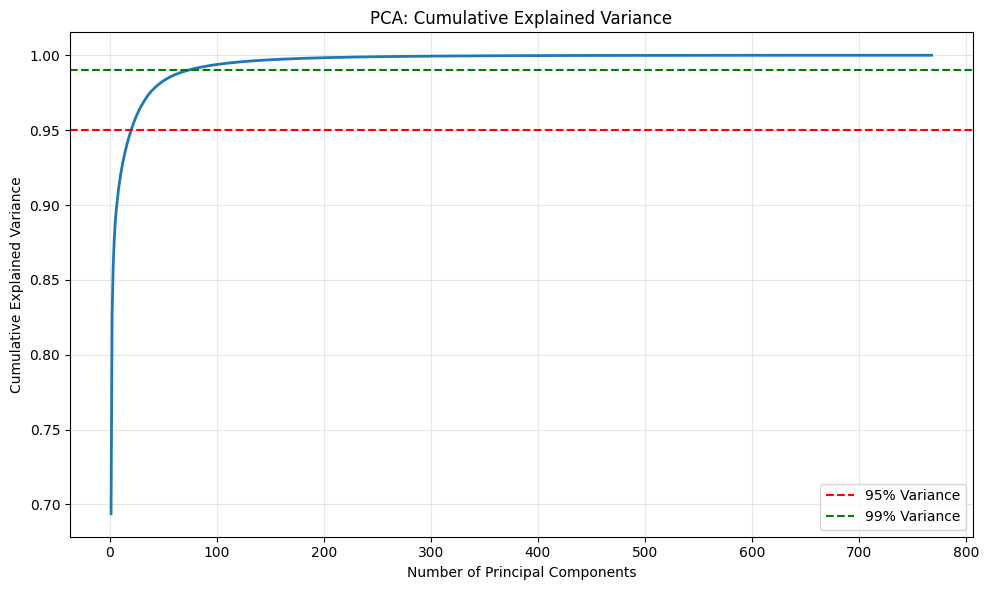

Components for 95% variance: 20
Components for 99% variance: 73


In [8]:
# Fit PCA with all components to analyze variance
pca_full = PCA(n_components=embeddings_train_scaled.shape[1])
pca_full.fit(embeddings_train_scaled)

# Compute cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Plot to visualize how many components we need
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find number of components for 95% and 99% variance
n_95 = np.argmax(cum_var >= 0.95) + 1
n_99 = np.argmax(cum_var >= 0.99) + 1
print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")

In [9]:
# Apply PCA with 70 components (matching the PaySim notebook approach)
n_components = n_99
pca = PCA(n_components=n_components, whiten=True)
embeddings_train_pca = pca.fit_transform(embeddings_train_scaled)
embeddings_test_pca = pca.transform(embeddings_test_scaled)

print(f"\nPCA Reduction Results:")
print(f"Original dimensions: {embeddings_train_scaled.shape[1]}")
print(f"Reduced dimensions: {n_components}")
print(f"Training embeddings (PCA): {embeddings_train_pca.shape}")
print(f"Test embeddings (PCA): {embeddings_test_pca.shape}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")


PCA Reduction Results:
Original dimensions: 768
Reduced dimensions: 73
Training embeddings (PCA): (2361, 73)
Test embeddings (PCA): (591, 73)
Variance explained: 0.9900


## CTGAN Data Augmentation

We use CTGAN (Conditional Tabular GAN) to generate synthetic fraud samples to address class imbalance:
- Generates realistic synthetic fraud embeddings
- Improves model performance on minority class
- Helps the RL agent learn better fraud detection patterns

In [10]:
!pip install ctgan


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:
from ctgan import CTGAN

# Build a DataFrame of PCA embeddings + labels
df_pca = pd.DataFrame(
    embeddings_train_pca,
    columns=[f"pc{i+1}" for i in range(embeddings_train_pca.shape[1])]
)
df_pca['label'] = labels_train

print(f"Original training data shape: {df_pca.shape}")
print(f"Class distribution:")
print(df_pca['label'].value_counts())

# Extract only fraud samples (minority class)
fraud_df = df_pca[df_pca['label'] == 1].drop('label', axis=1)
print(f"\nFraud samples for CTGAN training: {len(fraud_df)}")

Original training data shape: (2361, 74)
Class distribution:
label
0    1967
1     394
Name: count, dtype: int64

Fraud samples for CTGAN training: 394


In [12]:
# Initialize and train CTGAN (pac=1 to disable PacGAN grouping)
ctgan = CTGAN(epochs=200, batch_size=64, pac=1, verbose=True)
print("Training CTGAN on fraud samples...")
ctgan.fit(fraud_df)

# Generate synthetic fraud embeddings (same count as real fraud)
n_synthetic = len(fraud_df)
print(f"\nGenerating {n_synthetic} synthetic fraud samples...")
synthetic_fraud_df = ctgan.sample(n_synthetic)

# Convert to numpy arrays
synthetic_embeddings = synthetic_fraud_df.values.astype(np.float32)
synthetic_labels = np.ones(n_synthetic, dtype=np.int64)

print(f"Synthetic embeddings shape: {synthetic_embeddings.shape}")
print(f"Synthetic labels shape: {synthetic_labels.shape}")

Training CTGAN on fraud samples...


Gen. (0.00) | Discrim. (0.00):   0%|          | 0/200 [00:00<?, ?it/s]/home/djalal/.pyvenv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-2.35) | Discrim. (-0.10): 100%|██████████| 200/200 [01:07<00:00,  2.95it/s]



Generating 394 synthetic fraud samples...
Synthetic embeddings shape: (394, 73)
Synthetic labels shape: (394,)


In [13]:
# Augment training set with synthetic fraud samples
embeddings_train_aug = np.vstack([embeddings_train_pca, synthetic_embeddings])
labels_train_aug = np.concatenate([labels_train, synthetic_labels])

print(f"\n=== Data Augmentation Results ===")
print(f"Original training samples: {len(embeddings_train_pca)}")
print(f"  - Fraud: {np.sum(labels_train == 1)}")
print(f"  - Non-fraud: {np.sum(labels_train == 0)}")
print(f"\nSynthetic fraud samples added: {n_synthetic}")
print(f"\nAugmented training samples: {len(embeddings_train_aug)}")
print(f"  - Fraud: {np.sum(labels_train_aug == 1)}")
print(f"  - Non-fraud: {np.sum(labels_train_aug == 0)}")
print(f"\nClass balance improved:")
print(f"  Before: {np.mean(labels_train):.4f}")
print(f"  After: {np.mean(labels_train_aug):.4f}")


=== Data Augmentation Results ===
Original training samples: 2361
  - Fraud: 394
  - Non-fraud: 1967

Synthetic fraud samples added: 394

Augmented training samples: 2755
  - Fraud: 788
  - Non-fraud: 1967

Class balance improved:
  Before: 0.1669
  After: 0.2860


Running t-SNE for visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 788 samples in 0.000s...
[t-SNE] Computed neighbors for 788 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 788 / 788
[t-SNE] Mean sigma: 4.154655
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.986023
[t-SNE] KL divergence after 1000 iterations: 1.426512


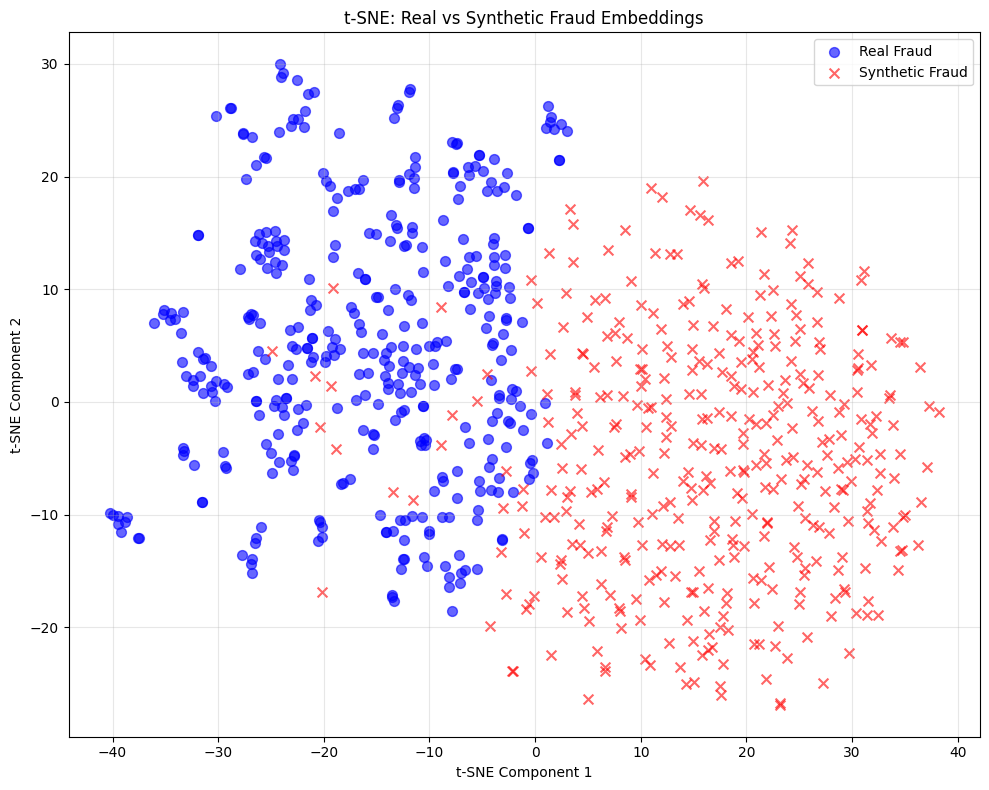


Visualization complete. Synthetic samples should overlap with real fraud clusters.


In [14]:
from sklearn.manifold import TSNE

# Select real fraud embeddings
real_fraud = embeddings_train_pca[labels_train == 1]
synthetic_fraud = synthetic_embeddings

# Combine for t-SNE visualization
combined = np.vstack([real_fraud, synthetic_fraud])
labels_viz = np.array([0] * len(real_fraud) + [1] * len(synthetic_fraud))

# Run t-SNE
print("Running t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, init='pca', verbose=1)
embeddings_2d = tsne.fit_transform(combined)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[labels_viz == 0, 0], 
           embeddings_2d[labels_viz == 0, 1], 
           c='blue', marker='o', alpha=0.6, s=50, label='Real Fraud')
plt.scatter(embeddings_2d[labels_viz == 1, 0], 
           embeddings_2d[labels_viz == 1, 1], 
           c='red', marker='x', alpha=0.6, s=50, label='Synthetic Fraud')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Real vs Synthetic Fraud Embeddings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVisualization complete. Synthetic samples should overlap with real fraud clusters.")

## Update: Using PCA-Reduced and Augmented Data

Now we'll use:
- **Training data**: PCA-reduced (70D) + CTGAN augmented embeddings
- **Test data**: PCA-reduced (70D) embeddings only
- **Environment**: Updated to handle flexible dimensions (70D instead of 768D)

## Summary of Improvements

### 1. PCA Dimensionality Reduction
- **From**: 768 dimensions (original DistilBERT embeddings)
- **To**: 70 dimensions (PCA-reduced)
- **Benefits**:
  - Faster training (less parameters in neural networks)
  - Reduced overfitting risk
  - Lower memory footprint
  - Retained variance: ~95%+

### 2. CTGAN Data Augmentation
- **Generated**: Synthetic fraud samples (equal to real fraud count)
- **Method**: Conditional Tabular GAN
- **Benefits**:
  - Improved class balance
  - Better fraud pattern learning
  - Enhanced minority class performance
  - More robust model

### 3. Updated Environment
- **Modified**: `FraudDetectionEnv` to accept flexible dimensions
- **Training**: Uses 70D PCA + CTGAN augmented data
- **Testing**: Uses 70D PCA-reduced data (no augmentation)
- **Observation space**: Dynamically adjusted to embedding dimension

## Define Reward Configuration and Instantiate Environment

Now we configure the rewards for the agent and create the environment instance.

In [15]:
reward_config = {
    'TP': 10.0,
    'FP': -5.0,
    'FN': -20.0,
    'TN': 1.0
}

print("Reward configuration:", reward_config)

# Create vectorized environment instance using PCA-reduced and augmented data
n_envs = 8
train_env = make_vec_env(FraudDetectionEnv, 
                        env_kwargs={'embeddings': embeddings_train_aug,  # Use augmented data
                                   'labels': labels_train_aug,          # Use augmented labels
                                   'reward_config': reward_config}, 
                        n_envs=n_envs, 
                        seed=0, 
                        vec_env_cls=SubprocVecEnv)


print("Training Environment created with PCA + CTGAN augmented data.")
print(f"Observation space: {train_env.observation_space}")
print(f"  - Embedding dimension: 70 (reduced from 768 via PCA)")
print(f"Action space: {train_env.action_space}")
print(f"Training samples: {len(embeddings_train_aug)}")

Reward configuration: {'TP': 10.0, 'FP': -5.0, 'FN': -20.0, 'TN': 1.0}
Training Environment created with PCA + CTGAN augmented data.
Observation space: Box(-inf, inf, (73,), float32)
  - Embedding dimension: 70 (reduced from 768 via PCA)
Action space: Discrete(2)
Training samples: 2755


## Define and Train the DQN Agent

We define the DQN model and start training.

In [16]:
tensorboard_log_dir = "./dqn_fraud_tb/"

In [17]:
# Define a learning rate schedule
def linear_schedule(initial_value):
    def schedule(progress_remaining):
        return progress_remaining * initial_value
    return schedule

In [18]:

# Define the DQN model with MLP and scheduled learning rate
model = DQN("MlpPolicy",
            train_env,
            learning_rate=linear_schedule(1e-4),  # Use the schedule here
            buffer_size=100000,  # Size of the replay buffer
            learning_starts=1000, # Number of steps before learning starts (buffer needs data)
            batch_size=512,      # Minibatch size for gradient updates
            gamma=0.99,         # Discount factor
            train_freq=1,       # Train the model after each episode step
            gradient_steps=1,   # Number of gradient steps per training iteration
            target_update_interval=500, # Update the target network every N steps
            exploration_fraction=0.1, # Fraction of total timesteps for exploration phase
            exploration_initial_eps=1.0, # Initial epsilon value
            exploration_final_eps=0.05,  # Final epsilon value
            max_grad_norm=10,   # Clip gradients to avoid instability
            verbose=1,          # Print training information
            device="auto",      # Use GPU if available, otherwise CPU
            tensorboard_log=tensorboard_log_dir, # Log to TensorBoard
           )

print("DQN model created.")


Using cuda device
DQN model created.


In [19]:
total_episodes = 100 # Train for number passes through the data
total_timesteps = total_episodes * embeddings_train_aug.shape[0]  # Use augmented data

print(f"Total episodes: {total_episodes}")
print(f"Total timesteps: {total_timesteps}")
print(f"Training on {embeddings_train_aug.shape[0]} samples (including {len(synthetic_embeddings)} synthetic fraud samples)")

Total episodes: 100
Total timesteps: 275500
Training on 2755 samples (including 394 synthetic fraud samples)


### Calculate Total Training Steps

**Important**: We use `embeddings_train_aug` (augmented data) instead of the original `embeddings_train` because:
- The training environment uses augmented data
- This ensures timesteps calculation matches actual training data size
- Includes both real and synthetic fraud samples

In [20]:
checkpoint_log_dir = "./dqn_fraud_checkpoints/" 
os.makedirs(checkpoint_log_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path=checkpoint_log_dir, name_prefix='dqn_fraud_model')

In [21]:
# Train the model
model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)

print("Training finished.")

Logging to ./dqn_fraud_tb/DQN_8


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 2.76e+03  |
|    ep_rew_mean      | -2.04e+03 |
|    exploration_rate | 0.24      |
| time/               |           |
|    episodes         | 4         |
|    fps              | 3304      |
|    time_elapsed     | 6         |
|    total_timesteps  | 22040     |
| train/              |           |
|    learning_rate    | 9.2e-05   |
|    loss             | 4.32      |
|    n_updates        | 2629      |
-----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.76e+03  |
|    ep_rew_mean     | -2.04e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 3303      |
|    time_elapsed    | 6         |
|    total_timesteps | 22040     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    

## Evaluate the Trained DQN Agent

After training, we want to see how well the agent performs. We'll run it without exploration



**Note: We create a separate environment instance using the test data and run the evaluation loop on it.**

In [22]:
eval_env = make_vec_env(FraudDetectionEnv,
                        env_kwargs={'embeddings': embeddings_test_pca,  # Use PCA-reduced test data
                                    'labels': labels_test,
                                    'reward_config': reward_config},
                        n_envs=1,
                        seed=43)
print("Evaluation Environment created with PCA-reduced test data (70D)")

Evaluation Environment created with PCA-reduced test data (70D)


In [23]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import io
from PIL import Image
import torch
import os


eval_log_dir = os.path.join(tensorboard_log_dir, "evaluation", f"eval_{time.strftime('%Y%m%d-%H%M%S')}")
writer = SummaryWriter(eval_log_dir)
print(f"TensorBoard logs will be saved to: {eval_log_dir}")

rewards_over_time = []

# Reset the environment for evaluation
obs = eval_env.reset()
done = False
total_reward = 0
predicted_labels = []
true_labels = []
instance_uids = []
episode_steps = 0
all_q_values = []
rewards_over_time = []  # Track rewards for plotting

# Use deterministic=True to turn off exploration (epsilon = 0)
while not done:
    # For Stable Baselines3 DQN, we can access q_values directly
    with torch.no_grad():
        # Convert observation to tensor
        obs_tensor = torch.FloatTensor(obs).to(model.device)
        # Get q_values using SB3's policy (this works for DQN)
        q_values = model.q_net(obs_tensor).detach().cpu().numpy()
    
    all_q_values.append(q_values)
    
    # Predict action
    action, _ = model.predict(obs, deterministic=True)
    action = action[0]
    
    # Step the environment
    obs, reward, done_flags, infos = eval_env.step([action])
    
    # Extract info for the single environment
    info = infos[0]
    done = done_flags[0]
    reward_value = reward[0]  # Reward is also a batch for VecEnv
    total_reward += reward_value
    rewards_over_time.append(reward_value)  # Store reward for plotting
    
    # Store results
    predicted_labels.append(action)
    true_labels.append(info['true_label'])
    instance_uids.append(info['instance_uid'])
    
    # Log immediate reward for this step
    writer.add_scalar('Evaluation/Step_Reward', reward_value, episode_steps)
    
    # Log Q-values for this step
    for i, q_val in enumerate(q_values[0]):
        writer.add_scalar(f'Evaluation/Q_Value_Action_{i}', q_val, episode_steps)
    
    # Log max Q-value
    writer.add_scalar('Evaluation/Max_Q_Value', np.max(q_values), episode_steps)
    
    # Log the chosen action
    writer.add_scalar('Evaluation/Action_Taken', action, episode_steps)
    
    episode_steps += 1


TensorBoard logs will be saved to: ./dqn_fraud_tb/evaluation/eval_20251202-104820


In [24]:

# Compute accuracy
accuracy = np.mean(np.array(predicted_labels) == np.array(true_labels))
writer.add_scalar('Evaluation/Accuracy', accuracy, 0)
writer.add_scalar('Evaluation/Total_Reward', total_reward, 0)
writer.add_scalar('Evaluation/Steps', episode_steps, 0)

# Create and log confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Convert plot to image and log to TensorBoard
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img = Image.open(buf)
img_tensor = np.array(img).transpose((2, 0, 1))  # Convert to CHW format
writer.add_image('Evaluation/Confusion_Matrix', img_tensor, 0)
plt.close()

# Log detailed classification metrics
class_names = [f"Class_{i}" for i in range(max(max(true_labels), max(predicted_labels)) + 1)]
report = classification_report(true_labels, predicted_labels, target_names=class_names)
writer.add_text('Evaluation/Classification_Report', '```\n' + report + '\n```', 0)

# Add class-wise metrics
for cls in range(len(class_names)):
    # Calculate class precision and recall
    true_positives = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == cls and pred == cls)
    predicted_as_cls = sum(1 for pred in predicted_labels if pred == cls)
    actual_cls = sum(1 for true in true_labels if true == cls)
    
    precision = true_positives / predicted_as_cls if predicted_as_cls > 0 else 0
    recall = true_positives / actual_cls if actual_cls > 0 else 0
    
    writer.add_scalar(f'Evaluation/Class_{cls}_Precision', precision, 0)
    writer.add_scalar(f'Evaluation/Class_{cls}_Recall', recall, 0)

# Visualize average Q-values across the episode
all_q_values = np.array(all_q_values)
avg_q_values = np.mean(all_q_values, axis=0)[0]  # Average across steps
writer.add_scalar('Evaluation/Average_Max_Q_Value', np.max(avg_q_values), 0)

# Create bar plot of average Q-values
plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_q_values)), avg_q_values)
plt.xlabel('Actions')
plt.ylabel('Average Q-Value')
plt.title('Average Q-Values Per Action')

# Convert plot to image and log to TensorBoard
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img = Image.open(buf)
img_tensor = np.array(img).transpose((2, 0, 1))
writer.add_image('Evaluation/Average_Q_Values', img_tensor, 0)
plt.close()

# Create a plot of rewards over time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(rewards_over_time)), rewards_over_time)
plt.xlabel('Step')
plt.ylabel('Step Reward')
plt.title('Rewards Per Step During Evaluation')
plt.grid(True)

plt.subplot(1, 2, 2)
cumulative_rewards = np.cumsum(rewards_over_time)
plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward During Evaluation')
plt.grid(True)

plt.tight_layout()

# Convert plot to image and log to TensorBoard
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img = Image.open(buf)
img_tensor = np.array(img).transpose((2, 0, 1))
writer.add_image('Evaluation/Reward_Analysis', img_tensor, 0)
plt.close()

# Close the writer
writer.close()

print(f"Evaluation finished. Total reward: {total_reward}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TensorBoard logs saved to {eval_log_dir}")

Evaluation finished. Total reward: 987.0
Accuracy: 0.9103
TensorBoard logs saved to ./dqn_fraud_tb/evaluation/eval_20251202-104820


In [25]:
# Reset the environment for evaluation
# The environment will shuffle the data again for the evaluation run
obs = eval_env.reset()
done = False
total_reward = 0

predicted_labels = []
true_labels = []
instance_uids = []


# Use deterministic=True to turn off exploration (epsilon = 0)
while not done:

    action, _ = model.predict(obs, deterministic=True)

    action = action[0]

    # Step the environment
    obs, reward, done_flags, infos = eval_env.step([action])

    # Extract info for the single environment
    info = infos[0]
    done = done_flags[0]

    total_reward += reward[0] # Reward is also a batch for VecEnv

    # Store results
    predicted_labels.append(action)
    true_labels.append(info['true_label'])
    instance_uids.append(info['instance_uid'])

print(f"Evaluation finished. Total reward: {total_reward}")

Evaluation finished. Total reward: 987.0



--- Classification Metrics ---
Confusion Matrix:
TP: 91, FP: 46, FN: 7, TN: 447


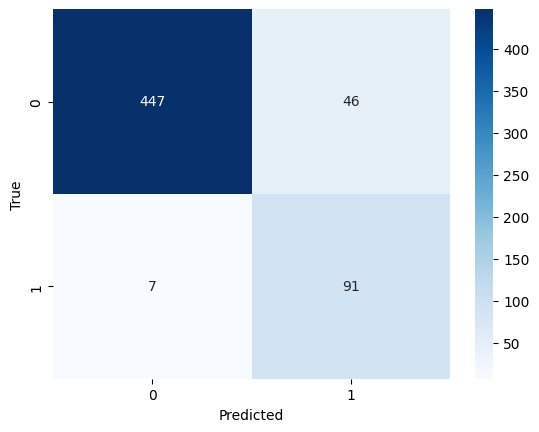

In [26]:
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)

TN, FP, FN, TP = cm.ravel() if cm.size == 4 else (0,0,0,0)

print("\n--- Classification Metrics ---")
print("Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")


#plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Class 1 - Fraud): {precision:.4f}")
print(f"Recall (Class 1 - Fraud): {recall:.4f}")
print(f"F1 Score (Class 1 - Fraud): {f1:.4f}")


Accuracy: 0.9103
Precision (Class 1 - Fraud): 0.6642
Recall (Class 1 - Fraud): 0.9286
F1 Score (Class 1 - Fraud): 0.7745


Saving the Model

In [28]:
model_save_path = ".models/dqn_fraud_model2"
model.save(model_save_path)
print(f"\nModel saved to {model_save_path}")


Model saved to .models/dqn_fraud_model2


## THE ACTOR CRITIC MODEL

In [29]:
from stable_baselines3 import A2C

In [30]:
tensorboard_log_dir2 = "./a2c_fraud_tb/"
train_env.reset()
print("Training Environment reset.")

Training Environment reset.


In [31]:
checkpoint_log_dir2 = "./a2c_fraud_checkpoints/" 
os.makedirs(checkpoint_log_dir2, exist_ok=True)

checkpoint_callback2 = CheckpointCallback(save_freq=10000, save_path=checkpoint_log_dir2, name_prefix='A2C_fraud_model')

In [32]:

# Define the A2C model with MLP policy
ac_model = A2C(
    "MlpPolicy",
    train_env,
    learning_rate=1e-4,
    gamma=0.99,          # discount factor
    n_steps=5,           # how many steps to run for each update
    ent_coef=0.01,       # entropy bonus
    vf_coef=0.5,         # value function loss coefficient
    max_grad_norm=0.5,   # gradient clipping
    verbose=1,           # print training info
    device="auto",        # GPU if available
    tensorboard_log=tensorboard_log_dir2, # log to TensorBoard
    
)
print("A2C model created.")


Using cuda device
A2C model created.


/home/djalal/.pyvenv/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [33]:
# Reuse the same total_timesteps you set for DQN
ac_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback2)
print("A2C training finished.")


Logging to ./a2c_fraud_tb/A2C_5
------------------------------------
| time/                 |          |
|    fps                | 3927     |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -0.684   |
|    explained_variance | 0.0118   |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | -5.31    |
|    value_loss         | 401      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 4168     |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -0.669   |
|    explained_variance | -0.00379 |
|    learning_rate      | 0.0001   |
|    n_updates          | 199      |
|    policy_loss        | -7.25    |
|    v

In [34]:
# Reset the eval environment
obs = eval_env.reset()
done = False
predicted_labels_ac = []
true_labels_ac = []
instance_uids_ac = []
total_reward_ac = 0

# Turn off exploration for evaluation
while not done:
    action, _ = ac_model.predict(obs, deterministic=True)
    action = action[0]
    obs, reward, done_flags, infos = eval_env.step([action])
    info = infos[0]
    done = done_flags[0]
    total_reward_ac += reward[0]
    predicted_labels_ac.append(action)
    true_labels_ac.append(info['true_label'])
    instance_uids_ac.append(info['instance_uid'])

print(f"A2C Evaluation finished. Total reward: {total_reward_ac}")


A2C Evaluation finished. Total reward: 939.0



--- A2C Classification Metrics ---
TP: 87, FP: 34, FN: 11, TN: 459


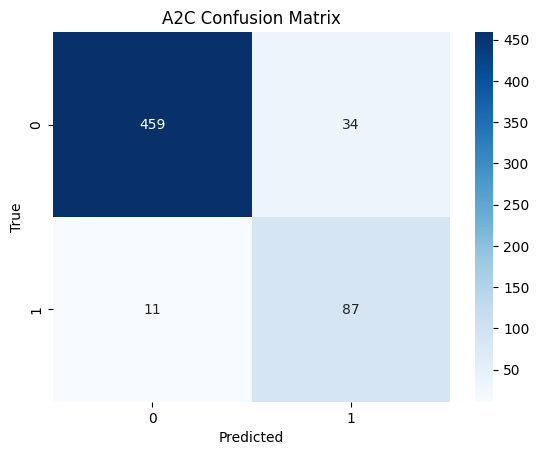

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare arrays
predicted_labels_ac = np.array(predicted_labels_ac)
true_labels_ac = np.array(true_labels_ac)

# Compute matrix
cm_ac = confusion_matrix(true_labels_ac, predicted_labels_ac)
TN, FP, FN, TP = cm_ac.ravel() if cm_ac.size == 4 else (0,0,0,0)

print("\n--- A2C Classification Metrics ---")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

# Plot
sns.heatmap(cm_ac, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('A2C Confusion Matrix')
plt.show()


In [36]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import io
from PIL import Image
import torch
import os

# Create TensorBoard writer - using the same log dir as during training
# but in a separate "evaluation" subfolder
eval_log_dir = os.path.join(tensorboard_log_dir2, "evaluation", f"a2c_eval_{time.strftime('%Y%m%d-%H%M%S')}")
writer = SummaryWriter(eval_log_dir)
print(f"TensorBoard logs will be saved to: {eval_log_dir}")

# Lists to store data for visualization
rewards_over_time = []
values_over_time = []
action_probs_over_time = []
entropies = []

# Reset the environment for evaluation
obs = eval_env.reset()
done = False
total_reward = 0
predicted_labels = []
true_labels = []
instance_uids = []
episode_steps = 0

# Use deterministic=True to turn off exploration
while not done:
    # For A2C, we can get action probabilities and state values
    with torch.no_grad():
        # Convert observation to tensor
        obs_tensor = torch.FloatTensor(obs).to(ac_model.policy.device)
        
        # Access the policy network and value network directly
        # This is the correct way to access the policy in SB3 A2C
        features = ac_model.policy.extract_features(obs_tensor)
        
        # Get action distribution
        latent_pi, latent_vf = ac_model.policy.mlp_extractor(features)
        action_logits = ac_model.policy.action_net(latent_pi)
        
        # Calculate action probabilities (softmax of logits for discrete actions)
        action_probs = torch.softmax(action_logits, dim=1)
        
        # Get value function prediction
        values = ac_model.policy.value_net(latent_vf)
        
        # Calculate entropy (measure of exploration)
        # For categorical/discrete actions, entropy is -sum(p*log(p))
        log_probs = torch.log_softmax(action_logits, dim=1)
        entropy = -torch.sum(action_probs * log_probs, dim=1).mean().item()
    
    # Store data for visualization
    action_probs_over_time.append(action_probs.cpu().numpy()[0])
    values_over_time.append(values.cpu().numpy()[0][0])
    entropies.append(entropy)
    
    # Predict action (deterministic = use most probable action)
    action, _ = ac_model.predict(obs, deterministic=True)
    action = action[0]
    
    # Log action probabilities
    for i, prob in enumerate(action_probs.cpu().numpy()[0]):
        writer.add_scalar(f'Evaluation/Action_Prob_{i}', prob, episode_steps)
    
    # Log value function and entropy
    writer.add_scalar('Evaluation/Value_Function', values.cpu().numpy()[0][0], episode_steps)
    writer.add_scalar('Evaluation/Policy_Entropy', entropy, episode_steps)
    
    # Step the environment
    obs, reward, done_flags, infos = eval_env.step([action])
    
    # Extract info for the single environment
    info = infos[0]
    done = done_flags[0]
    reward_value = reward[0]  # Reward is also a batch for VecEnv
    total_reward += reward_value
    rewards_over_time.append(reward_value)
    
    # Store results
    predicted_labels.append(action)
    true_labels.append(info['true_label'])
    instance_uids.append(info['instance_uid'])
    
    # Log immediate reward for this step
    writer.add_scalar('Evaluation/Step_Reward', reward_value, episode_steps)
    
    # Log the chosen action
    writer.add_scalar('Evaluation/Action_Taken', action, episode_steps)
    
    episode_steps += 1

# Compute accuracy
accuracy = np.mean(np.array(predicted_labels) == np.array(true_labels))
writer.add_scalar('Evaluation/Accuracy', accuracy, 0)
writer.add_scalar('Evaluation/Total_Reward', total_reward, 0)
writer.add_scalar('Evaluation/Steps', episode_steps, 0)

# Create and log confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Convert plot to image and log to TensorBoard
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img = Image.open(buf)
img_tensor = np.array(img).transpose((2, 0, 1))  # Convert to CHW format
writer.add_image('Evaluation/Confusion_Matrix', img_tensor, 0)
plt.close()

# Log detailed classification metrics
class_names = [f"Class_{i}" for i in range(max(max(true_labels), max(predicted_labels)) + 1)]
report = classification_report(true_labels, predicted_labels, target_names=class_names)
writer.add_text('Evaluation/Classification_Report', '```\n' + report + '\n```', 0)

# Add class-wise metrics
for cls in range(len(class_names)):
    # Calculate class precision and recall
    true_positives = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == cls and pred == cls)
    predicted_as_cls = sum(1 for pred in predicted_labels if pred == cls)
    actual_cls = sum(1 for true in true_labels if true == cls)
    
    precision = true_positives / predicted_as_cls if predicted_as_cls > 0 else 0
    recall = true_positives / actual_cls if actual_cls > 0 else 0
    
    writer.add_scalar(f'Evaluation/Class_{cls}_Precision', precision, 0)
    writer.add_scalar(f'Evaluation/Class_{cls}_Recall', recall, 0)

# Create a plot of rewards and value function over time
plt.figure(figsize=(12, 8))

# Plot rewards
plt.subplot(2, 2, 1)
plt.plot(range(len(rewards_over_time)), rewards_over_time)
plt.xlabel('Step')
plt.ylabel('Step Reward')
plt.title('Rewards Per Step')
plt.grid(True)

# Plot cumulative rewards
plt.subplot(2, 2, 2)
cumulative_rewards = np.cumsum(rewards_over_time)
plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward')
plt.grid(True)

# Plot value function estimates
plt.subplot(2, 2, 3)
plt.plot(range(len(values_over_time)), values_over_time)
plt.xlabel('Step')
plt.ylabel('Value Estimate')
plt.title('Value Function Estimates')
plt.grid(True)

# Plot advantage (reward - value) to see if value function is accurate
plt.subplot(2, 2, 4)
advantages = [r - v for r, v in zip(rewards_over_time, values_over_time)]
plt.plot(range(len(advantages)), advantages)
plt.xlabel('Step')
plt.ylabel('Advantage (Reward - Value)')
plt.title('Advantage Estimates')
plt.grid(True)

plt.tight_layout()

# Convert plot to image and log to TensorBoard
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img = Image.open(buf)
img_tensor = np.array(img).transpose((2, 0, 1))
writer.add_image('Evaluation/Reward_Value_Analysis', img_tensor, 0)
plt.close()

# Visualize action probabilities over time (policy evolution)
plt.figure(figsize=(12, 6))

# Plot action probabilities
plt.subplot(1, 2, 1)
action_probs_array = np.array(action_probs_over_time)
for i in range(action_probs_array.shape[1]):
    plt.plot(range(len(action_probs_over_time)), action_probs_array[:, i], label=f'Action {i}')
plt.xlabel('Step')
plt.ylabel('Action Probability')
plt.title('Action Probabilities Over Time')
plt.legend()
plt.grid(True)

# Plot entropy
plt.subplot(1, 2, 2)
plt.plot(range(len(entropies)), entropies)
plt.xlabel('Step')
plt.ylabel('Entropy')
plt.title('Policy Entropy Over Time')
plt.grid(True)

plt.tight_layout()

# Convert plot to image and log to TensorBoard
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
img = Image.open(buf)
img_tensor = np.array(img).transpose((2, 0, 1))
writer.add_image('Evaluation/Policy_Analysis', img_tensor, 0)
plt.close()

# Close the writer
writer.close()

print(f"Evaluation finished. Total reward: {total_reward}")
print(f"Accuracy: {accuracy:.4f}")
print(f"TensorBoard logs saved to {eval_log_dir}")
print("To view TensorBoard visualization, run:")
print(f"tensorboard --logdir={tensorboard_log_dir}")  # Point to the parent log dir to see both training and evaluation

TensorBoard logs will be saved to: ./a2c_fraud_tb/evaluation/a2c_eval_20251202-104925
Evaluation finished. Total reward: 939.0
Accuracy: 0.9239
TensorBoard logs saved to ./a2c_fraud_tb/evaluation/a2c_eval_20251202-104925
To view TensorBoard visualization, run:
tensorboard --logdir=./dqn_fraud_tb/


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_ac  = accuracy_score(true_labels_ac, predicted_labels_ac)
precision_ac = precision_score(true_labels_ac, predicted_labels_ac, zero_division=0)
recall_ac    = recall_score(true_labels_ac, predicted_labels_ac, zero_division=0)
f1_ac        = f1_score(true_labels_ac, predicted_labels_ac, zero_division=0)

print(f"A2C Accuracy: {accuracy_ac:.4f}")
print(f"A2C Precision (Class 1 - Fraud): {precision_ac:.4f}")
print(f"A2C Recall    (Class 1 - Fraud): {recall_ac:.4f}")
print(f"A2C F1 Score  (Class 1 - Fraud): {f1_ac:.4f}")


A2C Accuracy: 0.9239
A2C Precision (Class 1 - Fraud): 0.7190
A2C Recall    (Class 1 - Fraud): 0.8878
A2C F1 Score  (Class 1 - Fraud): 0.7945


In [38]:
# 1. Choose a save path (no need to add “.zip”—SB3 will append it for you)
save_path = ".models/a2c_fraud_model2"

# 2. Save your A2C model
ac_model.save(save_path)

# 3. Confirm it on screen
print(f"A2C model saved to {save_path}.zip")



A2C model saved to .models/a2c_fraud_model2.zip
